# 0.Constants

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_IDX=0
BERT_CLS_IDX=101
BERT_SEP_IDX=102

# 1.Importing Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 5.5MB/s 
     |████████████████████████████████| 890kB 29.6MB/s 
     |████████████████████████████████| 1.1MB 39.9MB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=889a02c45d6406f86e657f199840dd0322d9d3ad435cf2a31bb0b96f907c5620
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import csv
import shutil
import numpy as np
import copy
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from itertools import chain
from collections import Counter
import json
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import vgg19
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from transformers import BertTokenizer,BertModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 2.Preparing Dataset

In [ ]:
 !unzip drive/My\ Drive/Colab\ Data/mscoco.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./mscoco/COCO_train2014_000000486641.jpg  
  inflating: ./mscoco/COCO_train2014_000000486713.jpg  
  inflating: ./mscoco/COCO_train2014_000000486717.jpg  
  inflating: ./mscoco/COCO_train2014_000000486718.jpg  
  inflating: ./mscoco/COCO_train2014_000000486732.jpg  
  inflating: ./mscoco/COCO_train2014_000000486793.jpg  
  inflating: ./mscoco/COCO_train2014_000000486807.jpg  
  inflating: ./mscoco/COCO_train2014_000000486821.jpg  
  inflating: ./mscoco/COCO_train2014_000000486854.jpg  
  inflating: ./mscoco/COCO_train2014_000000486869.jpg  
  inflating: ./mscoco/COCO_train2014_000000486870.jpg  
  inflating: ./mscoco/COCO_train2014_000000486906.jpg  
  inflating: ./mscoco/COCO_train2014_000000486936.jpg  
  inflating: ./mscoco/COCO_train2014_000000486960.jpg  
  inflating: ./mscoco/COCO_train2014_000000486972.jpg  
  inflating: ./mscoco/COCO_train2014_000000486977.jpg  
  inflating: ./mscoco/COCO_train2014_000000486983.jpg

## 2.0.Vocabulary



In [ ]:
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
BERT_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True).to(DEVICE)
BERT_model.eval()

## 2.1.Batch Preparation Collate

In [ ]:
# Taken from HW4 Part3
def pad_tensor(tensor: torch.Tensor, size: int, dim: int=-1):
  """
  tensor: tensor to pad
  size: the size to pad to
  dim: dimension to pad
  returns a new tensor padded to 'size' in dimension 'dim'
  """
  pad_size = list(tensor.shape)
  pad_size[dim] = size - tensor.size(dim)
  pad = torch.full(pad_size, PAD_IDX, dtype=tensor.dtype, device=tensor.device)
  return torch.cat([tensor, pad], dim=dim)

# Thanks to https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8
class BatchPrepareCollate:
  def __init__(self,vgg,fcnn,mode='train',task='reg2cap'):
    self.vgg=vgg
    self.fcnn=fcnn
    self.mode=mode
    self.task=task
    self.vgg_transforms=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  def BatchPrepare_collate(self, batch,mode,task):

    if not task=='reg2cap':
      batch_image=[transforms.functional.to_tensor(s['image']).to(DEVICE) for s in batch]
      with torch.no_grad():
        fcnn_res=self.fcnn(batch_image)
      
      batch_image_boxes=[]
      for i in range(len(fcnn_res)):
        boxes,scores=fcnn_res[i]['boxes'].detach(),fcnn_res[i]['scores'].detach()
        most_likely_boxes=boxes[scores>=(0.75 if mode=='train' else 0.7)]
        if most_likely_boxes.size(0)>1:
          box_distances_to_true_box=torch.norm(most_likely_boxes-batch[i]['true_box'][:4],dim=1)
          nearest_box_idx=torch.argmin(box_distances_to_true_box).item()
          other_boxes=most_likely_boxes[[idx for idx in range(most_likely_boxes.shape[0]) if idx!=nearest_box_idx],:]
          if mode=='train':
            false_box=other_boxes[torch.randint(other_boxes.size(0),(1,)).item()]
            false_box_s=torch.tensor([(false_box[2]-false_box[0])*(false_box[3]-false_box[1])],device=DEVICE)  
            batch_image_boxes+=[torch.cat((false_box,false_box_s))]
          else:
            batch_image_boxes+=[torch.cat((other_boxes,((other_boxes[:,2]-other_boxes[:,0])*(other_boxes[:,3]-other_boxes[:,1])).unsqueeze(dim=1)),dim=1)]
        else:
          dummy_box=torch.zeros((4,),device=DEVICE)
          dummy_box_s=torch.zeros((1,),device=DEVICE)
          if mode=='train':
            batch_image_boxes+=[torch.cat((dummy_box,dummy_box_s))]
          else:
            batch_image_boxes+=[torch.cat((dummy_box,dummy_box_s)).unsqueeze(dim=0)]
      torch.cuda.empty_cache()
    
    imageVGGInputBatch=torch.stack([s['VGGimagePreLastLayerFeatures'] for s in batch]).to(DEVICE)
    batch_image_features=self.vgg['last'](imageVGGInputBatch)

    if not (mode=='test' and task=='reg2cap'):
      regionVGGInputBatch=torch.stack([s['VGGregionPreLastLayerFeatures'] for s in batch]).to(DEVICE)
      batch_region_features=self.vgg['last'](regionVGGInputBatch)

    if mode=='train' or task=='reg2cap':
      true_spatial_features=torch.stack([s['true_box']/s['spatial_features_denominator'] for s in batch])
      batch_true_box_2005_features=torch.cat((batch_image_features,batch_region_features,true_spatial_features),dim=1)

    if mode=='train' and task=='cap2reg':
      regions_vggInputs=[]
      for i in range(len(batch)):
        x_tl,y_tl,x_br,y_br=batch_image_boxes[i][:4].cpu().numpy()
        h,w=y_br-y_tl,x_br-x_tl
        regions_vggInputs+=[self.vgg_transforms(transforms.functional.crop(batch[i]['image'],x_tl,y_tl,h,w)).to(DEVICE)]      
      for i in range(len(batch)):
        batch_image_boxes[i]=batch_image_boxes[i]/batch[i]['spatial_features_denominator']
      batch_false_box_spatial_features=torch.stack(batch_image_boxes)
      with torch.no_grad():
        preLastLayer=self.vgg['feat-cls'](torch.stack(regions_vggInputs))
      region_features=self.vgg['last'](preLastLayer)
      batch_false_box_2005_features=torch.cat((batch_image_features,region_features,batch_false_box_spatial_features),dim=1)
    elif mode!='train' and task=='cap2reg':
      batch_image_regions_2005_features=[]
      for i in range(len(batch)):
        regions_vggInputs=[]
        for j in range(batch_image_boxes[i].size(0)):
          x_tl,y_tl,x_br,y_br=batch_image_boxes[i][j][:4].cpu().numpy()
          h,w=y_br-y_tl,x_br-x_tl
          regions_vggInputs+=[self.vgg_transforms(transforms.functional.crop(batch[i]['image'],x_tl,y_tl,h,w)).to(DEVICE)]
        with torch.no_grad():
          region_features=self.vgg['last'](self.vgg['feat-cls'](torch.stack(regions_vggInputs)))
        image_features=batch_image_features[i].repeat(batch_image_boxes[i].size(0),1)
        batch_image_regions_2005_features+=[torch.cat([image_features,region_features,batch_image_boxes[i]/batch[i]['spatial_features_denominator']],dim=1)]

    if not (mode=='test' and task=='reg2cap'):
      sentences=BERT_tokenizer.batch_encode_plus([sample['sentence'] for sample in batch],
                                       add_special_tokens=True,max_length=10,truncation=True,
                                       padding=True,return_tensors='pt',return_length=True)
      with torch.no_grad():
        _,_,embed_hiddens=BERT_model(input_ids=sentences['input_ids'].to(DEVICE),attention_mask=sentences['attention_mask'].to(DEVICE),token_type_ids=sentences['token_type_ids'].to(DEVICE))
      embeddings=embed_hiddens[-2]
      if mode=='valid' and task=='reg2cap':
        padding_mask=(sentences['attention_mask']!=1).to(DEVICE)
      if mode!='train' and task=='cap2reg':
        sentence_lengths=sentences['length']
      sentences=sentences['input_ids'].to(DEVICE)

    if mode=='train' and task=='cap2reg':
      return sentences,embeddings,batch_true_box_2005_features,batch_false_box_2005_features
    elif mode=='train' and task=='reg2cap':
      return sentences,embeddings,batch_true_box_2005_features
    elif mode=='valid' and task=='reg2cap':
      return sentences,embeddings,padding_mask,batch_true_box_2005_features
    elif mode=='test' and task=='reg2cap':
      return batch_true_box_2005_features
    else:
      return sentences,embeddings,sentence_lengths,batch_image_regions_2005_features,batch_true_box_2005_features,batch_image_boxes
  def __call__(self, batch):
    return self.BatchPrepare_collate(batch,self.mode,self.task)

## 2.2.Dataset Class

In [ ]:
class CapRegDataset(Dataset):
  def __init__(self,vgg,mode='train',task='reg2cap',csv_dir='/content/drive/My Drive/Colab Data/',coco_images_dir='mscoco/'):
    self.coco_images_dir=coco_images_dir
    self.samples=[]
    self.images_features={}
    self.mode=mode
    self.task=task
    self.vgg_transforms=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    fname='dataset.'+mode+'.csv'
    if mode=='test':
      if task=='reg2cap':
        fname='dataset.test.gen.csv'
      else:
        fname='dataset.test.comp.csv'
    with open(csv_dir+fname) as csvfile:
      reader=csv.reader(csvfile)
      key_names=next(reader)
      bstart=0
      length=0
      images=[]
      images_fnames=[]
      regions=[]
      for row in reader:
        sample=dict(zip(key_names,row))
        image=Image.open(self.coco_images_dir+sample['image_fname']).convert('RGB')
        if not (mode=='test' and task=='cap2reg'):
          sample['box']=[float(x) for x in sample['box'].replace('[','').replace(']','').split()]
          x_tl,y_tl,x_br,y_br=sample['box']
          regions+=[self.vgg_transforms(transforms.functional.crop(image,x_tl,y_tl,y_br-y_tl,x_br-x_tl))]
        if not (sample['image_fname'] in self.images_features):
          images+=[self.vgg_transforms(image)]
          images_fnames+=[sample['image_fname']]
          self.images_features[sample['image_fname']]=image
        length+=1
        self.samples+=[sample]
        if length==256:
          im_batch=torch.stack(images).to(DEVICE)
          with torch.no_grad():
            VGGimageFeatures=torch.unbind(vgg['feat-cls'](im_batch).detach().cpu())
          for i in range(len(VGGimageFeatures)):
            self.images_features[images_fnames[i]]=VGGimageFeatures[i]
          if not (mode=='test' and task=='cap2reg'):
            reg_batch=torch.stack(regions).to(DEVICE)
            with torch.no_grad():
              VGGregionFeatures=torch.unbind(vgg['feat-cls'](reg_batch).detach().cpu())
            for i in range(bstart,bstart+length):
                self.samples[i]['VGGregionPreLastLayerFeatures']=VGGregionFeatures[i-bstart]
          print('preparing {} samples finished!'.format(len(self.samples)))
          bstart+=length
          length=0
          images=[]
          regions=[]
          images_fnames=[]
      if length!=0:
        im_batch=torch.stack(images).to(DEVICE)
        with torch.no_grad():
          VGGimageFeatures=torch.unbind(vgg['feat-cls'](im_batch).detach().cpu())
        for i in range(len(VGGimageFeatures)):
            self.images_features[images_fnames[i]]=VGGimageFeatures[i]
        if not (mode=='test' and task=='cap2reg'):
          reg_batch=torch.stack(regions).to(DEVICE)
          with torch.no_grad():
            VGGregionFeatures=torch.unbind(vgg['feat-cls'](reg_batch).detach().cpu())
          for i in range(bstart,bstart+length):
              self.samples[i]['VGGregionPreLastLayerFeatures']=VGGregionFeatures[i-bstart]
        print('preparing {} samples finished!'.format(len(self.samples)))
        bstart+=length
        length=0
        images=[]
        regions=[]
        images_fnames=[]
      print('Reading Dataset file finished!')     
  def __len__(self):
    return len(self.samples)
  def __getitem__(self, idx):
    sample=self.samples[idx]
    if not (self.mode=='test' and self.task=='cap2reg'):
      x_tl,y_tl,x_br,y_br=sample['box']
      s_region=(x_br-x_tl)*(y_br-y_tl)
    image=Image.open(self.coco_images_dir+sample['image_fname']).convert('RGB')
    W,H=image.size    
    denominator=torch.tensor([W,H,W,H,W*H],dtype=torch.float,device=DEVICE)

    if (self.mode=='test' and self.task=='cap2reg'):
      return {'sentence':sample['sentence'],
            'spatial_features_denominator':denominator,
            'image':image,
            'VGGimagePreLastLayerFeatures':self.images_features[sample['image_fname']]}
    elif (self.mode=='test' and self.task=='reg2cap'):
      return {'true_box':torch.tensor([x_tl,y_tl,x_br,y_br,s_region],device=DEVICE),
            'spatial_features_denominator':denominator,
            'image':image,
            'VGGimagePreLastLayerFeatures':self.images_features[sample['image_fname']],
            'VGGregionPreLastLayerFeatures':sample['VGGregionPreLastLayerFeatures']
            }  
    return {'sentence':sample['sentence'],
            'true_box':torch.tensor([x_tl,y_tl,x_br,y_br,s_region],device=DEVICE),
            # 'true_box_size':(y_br-y_tl,x_br-x_tl),
            'spatial_features_denominator':denominator,
            'image':image,
            'VGGimagePreLastLayerFeatures':self.images_features[sample['image_fname']],
            'VGGregionPreLastLayerFeatures':sample['VGGregionPreLastLayerFeatures']
            }

# 3.Defining Model

In [ ]:
class CapRegModel(nn.Module):
  def __init__(self,task='reg2cap'):
    super(CapRegModel, self).__init__()
    self.task=task
    self.vocab_size=BERT_tokenizer.vocab_size
    self.hidden_size=1024
    self.embed_size=768
    self.lstm=nn.LSTMCell(2005+self.embed_size,self.hidden_size)
    self.pre_vocab_dropout=nn.Dropout(p=0.5)
    self.lstm_to_vocab=nn.Linear(self.hidden_size,self.vocab_size,bias=False)
  def change_task(self,task):
    self.task=task
  def forward(self,args):
    if self.training and self.task=='cap2reg':
      sentences,embeddings,batch_true_box_2005_features,batch_false_box_2005_features=args
      combined_batch_input1=[]
      combined_batch_input2=[]
      sentences_combined=[]
      for i in range(batch_true_box_2005_features.size(0)*2):
        idx=i//2 if (i%2==0) else (i-1)//2
        row=batch_true_box_2005_features[idx] if (i%2==0) else batch_false_box_2005_features[idx]
        combined_batch_input1+=[row]
        input2=embeddings[idx,:-1]
        combined_batch_input2+=[input2]
        sentences_combined+=[sentences[idx,1:]]
      lstm_input2=torch.stack(combined_batch_input2)#shape after: (2*B,T,embed_size)
      lstm_input1=torch.stack(combined_batch_input1)#shape after: (2*B,2005)
      h,c=[torch.zeros((batch_true_box_2005_features.size(0)*2,self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_logits=[]
      for t in range(sentences.size(1)-1):
        lstm_input=torch.cat([lstm_input1,lstm_input2[:,t,:]],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.pre_vocab_dropout(h)
        all_logits+=[self.lstm_to_vocab(h_dropout)]
      logits=torch.stack(all_logits,dim=2)#shape after: (B,F,T).to be able to feed into CrossEntropy
      loss=F.cross_entropy(logits,torch.stack(sentences_combined),reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      return torch.mean(torch.sum(loss[[2*i for i in range(batch_true_box_2005_features.size(0))]],dim=1))-torch.mean(torch.sum(loss[[2*i+1 for i in range(batch_false_box_2005_features.size(0))]],dim=1))
    elif self.training and self.task=='reg2cap':
      sentences,embeddings,batch_true_box_2005_features=args
      h,c=[torch.zeros((batch_true_box_2005_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_logits=[]
      for t in range(sentences.size(1)-1):
        if t==0:
          lstm_input2=embeddings[:,t]
        else:
          if np.random.uniform()<=0.7:
            lstm_input2=embeddings[:,t]
          else:
            input2=torch.multinomial(F.softmax(logits,dim=1),1)
            with torch.no_grad():
              lstm_input2=BERT_model(torch.cat((sentences[:,:t],input2),dim=1))[2][-2][:,-1]
        lstm_input=torch.cat([batch_true_box_2005_features,lstm_input2],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.pre_vocab_dropout(h)
        logits=self.lstm_to_vocab(h_dropout)
        all_logits+=[logits]
      loss=F.cross_entropy(torch.stack(all_logits,dim=2),sentences[:,1:],reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      return torch.mean(torch.sum(loss,dim=1))      
    elif self.task=='reg2cap':
      sentences,embeddings,padding_mask,batch_true_box_2005_features=args
      preds=[]
      lstm_input2=embeddings[:,0]
      h,c=[torch.zeros((batch_true_box_2005_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_logits=[]
      for t in range(sentences.size(1)-1):
        lstm_input=torch.cat([batch_true_box_2005_features,lstm_input2],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.pre_vocab_dropout(h)
        logits=self.lstm_to_vocab(h_dropout)
        pred=torch.multinomial(F.softmax(logits,dim=1),1)
        preds+=[pred.squeeze(dim=1)]
        all_logits+=[logits]
        with torch.no_grad():
          lstm_input2=BERT_model(torch.cat((torch.stack(preds,dim=1),pred),dim=1))[2][-2][:,-1]
      loss=F.cross_entropy(torch.stack(all_logits,dim=2),sentences[:,1:],reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      preds_padding_restored=torch.stack(preds,dim=1).masked_fill_(padding_mask[:,1:],0)
      return torch.mean(torch.sum(loss,dim=1)),preds_padding_restored
    else:
      #batch_image_regions_2005_features: List(len:batchSize)[Tensor(regionCnt(depends on image),2005)]
      sentences,embeddings,sentence_lengths,batch_image_regions_2005_features,batch_true_box_2005_features,batch_image_boxes=args
      batch_region_cnts=[s.size(0) for s in batch_image_regions_2005_features]
      #input_tensor1 shape: (sigma on B(R_i),T,2005)
      lstm_input1=torch.cat([s.unsqueeze(dim=1).expand((s.size(0),sentences.size(1)-1,2005)) for s in batch_image_regions_2005_features],dim=0)
      ##input_tensor2 shape: (sigma on B(R_i),T,embed_size)
      lstm_input2=torch.cat([embeddings[i][:-1].unsqueeze(dim=0).expand((batch_image_regions_2005_features[i].size(0),sentences.size(1)-1,self.embed_size)) for i in range(sentences.size(0))],dim=0)
      lstm_input12=torch.cat([lstm_input1,lstm_input2],dim=2)
      h,c=[torch.zeros((sum(batch_region_cnts),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_log_probs=[]
      for t in range(sentences.size(1)-1):
        lstm_input=lstm_input12[:,t,:]
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.pre_vocab_dropout(h)
        logits=self.lstm_to_vocab(h_dropout)
        all_log_probs+=[F.log_softmax(logits,dim=1)]
      log_probs=torch.stack(all_log_probs,dim=1)
      regionNum=0
      best_regions=[]
      for i in range(len(batch_image_regions_2005_features)):
        sample_log_probs=log_probs[regionNum:regionNum+batch_region_cnts[i]]
        sample_log_probs_unpadded=sample_log_probs[:,:sentence_lengths[i]-1]
        sample_regions_log_probs=torch.sum(sample_log_probs_unpadded[:,list(range(sentence_lengths[i]-1)),sentences[i,1:sentence_lengths[i]]],dim=1)
        best_regions+=[(batch_image_boxes[i][torch.argmax(sample_regions_log_probs,dim=0)],torch.exp(torch.max(sample_regions_log_probs,dim=0)[0]))]
        regionNum+=batch_region_cnts[i]
      return best_regions
  def generate_caption(self,batch):
      batch_true_box_2005_features=batch
      max_len_sentence=16
      predictions=[]
      for i in range(batch_true_box_2005_features.size(0)):
        preds=[]
        input2=torch.tensor([BERT_CLS_IDX],device=DEVICE)
        with torch.no_grad():
          lstm_input2=BERT_model(input2)[2][-2][0,-1]
        h,c=[torch.zeros((1,self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
        for t in range(max_len_sentence-1):
          lstm_input=torch.cat([batch_true_box_2005_features[i],lstm_input2]).unsqueeze(dim=0)
          h,c=self.lstm(lstm_input,(h,c))
          h_dropout=self.pre_vocab_dropout(h)
          logits=self.lstm_to_vocab(h_dropout)
          pred=torch.multinomial(F.softmax(logits[0],dim=0),1)
          preds+=[pred.item()]
          if pred.item()==BERT_SEP_IDX:
            break
          with torch.no_grad():
            lstm_input2=BERT_model(torch.tensor([BERT_CLS_IDX]+preds,device=DEVICE))[2][-2][0,-1]
        predictions+=[preds]
      return predictions

# 4.Training Procedure

## 4.0. Hyperparameters

In [ ]:
BATCH_SIZE=256
LR=0.001
EPOCHS=20

## 4.1. Instantiating Classes

In [ ]:
fcnn=fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
fcnn.eval()
vgg19_model = vgg19(pretrained=True)
vggLastLayer=copy.deepcopy(vgg19_model.classifier[6]).to(DEVICE)
# for param in vggLastLayer.parameters():
#   param.requires_grad = False
print(vggLastLayer.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_vgglast_loss40.7.pt')))
for param in vgg19_model.parameters():
  param.requires_grad = False
del vgg19_model.classifier[6]
vgg19_model=vgg19_model.to(DEVICE)
vgg19_model.eval()
vgg={'feat-cls':vgg19_model,'last':vggLastLayer}

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



<All keys matched successfully>


In [ ]:
trainDS=CapRegDataset(vgg)
testDS=CapRegDataset(vgg,mode='valid')

preparing 256 samples finished!
preparing 512 samples finished!
preparing 768 samples finished!
preparing 1024 samples finished!
preparing 1280 samples finished!
preparing 1536 samples finished!
preparing 1792 samples finished!
preparing 2048 samples finished!
preparing 2304 samples finished!
preparing 2560 samples finished!
preparing 2816 samples finished!
preparing 3072 samples finished!
preparing 3328 samples finished!
preparing 3584 samples finished!
preparing 3840 samples finished!
preparing 4096 samples finished!
preparing 4352 samples finished!
preparing 4608 samples finished!
preparing 4864 samples finished!
preparing 5120 samples finished!
preparing 5376 samples finished!
preparing 5632 samples finished!
preparing 5888 samples finished!
preparing 6144 samples finished!
preparing 6400 samples finished!
preparing 6656 samples finished!
preparing 6912 samples finished!
preparing 7168 samples finished!
preparing 7424 samples finished!
preparing 7680 samples finished!
preparing 793

In [ ]:
trainDL=DataLoader(trainDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn))
reg2capTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='valid'))
cap2regTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='valid',task='cap2reg'))

In [ ]:
model=CapRegModel().to(DEVICE)
print(model.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_loss40.7.pt')))

<All keys matched successfully>


In [ ]:
optimizer=torch.optim.Adam(list(model.parameters())+list(vgg['last'].parameters()),lr=LR)
print(optimizer.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_optim_loss40.7.pt')))

None


## 4.2.Train Loop

In [ ]:
epochs_train_losses=[]
epochs_test_losses=[]
train_batch_cnt=len(trainDS)//BATCH_SIZE
test_batch_cnt=len(testDS)//BATCH_SIZE

In [ ]:
f=open('drive/My Drive/Colab Data/loss_history.json','r')
d=json.loads(f.read())
epochs_train_losses=d['train']
epochs_test_losses=d['test']

In [ ]:
for epoch in range(6,EPOCHS):
  batches_train_losses=[]
  for num,batch in enumerate(trainDL):
    model.zero_grad()
    loss=model(batch)
    loss.backward()
    optimizer.step()
    batches_train_losses+=[loss.item()]
    if num%10==0:
      avg_loss=np.mean(batches_train_losses)
      print('Train ,Epoch#{} ,batch {}/{} ,avg-loss: {}'.format(epoch+1,num+1,train_batch_cnt,avg_loss))
  epoch_loss=np.mean(batches_train_losses)
  print('Train ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
  if (epoch>0 and epoch_loss<min(epochs_train_losses)) or epoch+1==EPOCHS:
    torch.save(model.state_dict(),'DL_FP_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss))
    shutil.move('DL_FP_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss),'drive/My Drive/Colab Data')
    torch.save(optimizer.state_dict(),'DL_FP_optim_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss))
    shutil.move('DL_FP_optim_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss),'drive/My Drive/Colab Data')
    torch.save(vgg['last'].state_dict(),'DL_FP_vgglast_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss))
    shutil.move('DL_FP_vgglast_epoch{}_loss{:.1f}.pt'.format(epoch+1,epoch_loss),'drive/My Drive/Colab Data')
  epochs_train_losses+=[epoch_loss]
  #####Test
  model.eval()
  vggLastLayer.eval()
  # vgg19_model.eval()
  model.change_task('reg2cap')
  batches_test_losses=[]
  for num,batch in enumerate(reg2capTestDL):
    with torch.no_grad():
      loss,preds=model(batch)
      batches_test_losses+=[loss.item()]
      if num%10==0:
        avg_loss=np.mean(batches_test_losses)
        print('Test ,batch {}/{} ,avg-loss: {}'.format(num+1,test_batch_cnt,avg_loss))
  model.train()
  vggLastLayer.train()
  # vgg19_model.train()
  epoch_loss=np.mean(batches_test_losses)
  epochs_test_losses+=[epoch_loss]
  print('Test ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
  f=open('drive/My Drive/Colab Data/loss_history.json','w')
  s=json.dumps({'train':epochs_train_losses,'test':epochs_test_losses})
  f.write(s)
  f.close()

Train ,Epoch#7 ,batch 1/314 ,avg-loss: 41.01034927368164
Train ,Epoch#7 ,batch 11/314 ,avg-loss: 40.75520498102362
Train ,Epoch#7 ,batch 21/314 ,avg-loss: 40.69601022629511
Train ,Epoch#7 ,batch 31/314 ,avg-loss: 40.585184651036414
Train ,Epoch#7 ,batch 41/314 ,avg-loss: 40.55281978700219
Train ,Epoch#7 ,batch 51/314 ,avg-loss: 40.56238802741556
Train ,Epoch#7 ,batch 61/314 ,avg-loss: 40.56787321997471
Train ,Epoch#7 ,batch 71/314 ,avg-loss: 40.59896452997772
Train ,Epoch#7 ,batch 81/314 ,avg-loss: 40.59430576842508
Train ,Epoch#7 ,batch 91/314 ,avg-loss: 40.591339237087375
Train ,Epoch#7 ,batch 101/314 ,avg-loss: 40.60013281944955
Train ,Epoch#7 ,batch 111/314 ,avg-loss: 40.601710035994245
Train ,Epoch#7 ,batch 121/314 ,avg-loss: 40.59905012777029
Train ,Epoch#7 ,batch 131/314 ,avg-loss: 40.61085224879607
Train ,Epoch#7 ,batch 141/314 ,avg-loss: 40.636269075650695
Train ,Epoch#7 ,batch 151/314 ,avg-loss: 40.62762463803323
Train ,Epoch#7 ,batch 161/314 ,avg-loss: 40.624623126865174
Tra

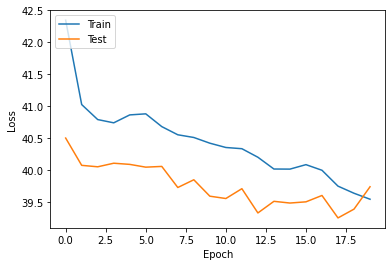

In [ ]:
plt.plot(epochs_train_losses)
plt.plot(epochs_test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

# 5.Evaluation

In [ ]:
vocab=Vocab.load('drive/My Drive/Colab Data/DL_FP_vocab.vo')

In [ ]:
validDS=CapRegDataset(vgg,mode='valid',vocab=vocab)

preparing 256 samples finished!
preparing 512 samples finished!
preparing 768 samples finished!
preparing 1024 samples finished!
preparing 1280 samples finished!
preparing 1536 samples finished!
preparing 1792 samples finished!
preparing 2048 samples finished!
preparing 2304 samples finished!
preparing 2560 samples finished!
preparing 2816 samples finished!
preparing 3072 samples finished!
preparing 3328 samples finished!
preparing 3584 samples finished!
preparing 3840 samples finished!
preparing 4096 samples finished!
preparing 4352 samples finished!
preparing 4608 samples finished!
preparing 4864 samples finished!
preparing 4895 samples finished!
Reading Dataset file finished!


In [ ]:
model=CapRegModel(vocab.size).to(DEVICE)
print(model.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_epoch15_loss50.752.pt')))

<All keys matched successfully>


In [ ]:
reg2capTestDL=DataLoader(validDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test'))
cap2regTestDL=DataLoader(validDS,batch_size=8,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test',task='cap2reg'))

In [ ]:
test_batch_cnt=len(validDS)//BATCH_SIZE
model.eval()
vgg['last'].eval()
model.change_task('reg2cap')
cap_predictions=[]
for num,batch in enumerate(reg2capTestDL):
    with torch.no_grad():
      preds=model.generate_caption(batch)
    for i in range(len(preds)):
      preds[i]=' '.join([vocab.get_token_by_id(id) for id in preds[i]])
    cap_predictions+=preds
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))

Test ,batch 1/38
Test ,batch 11/38
Test ,batch 21/38
Test ,batch 31/38


In [ ]:
import pandas as pd
tgt_frame=pd.read_csv('dataset.valid.csv')
from bleu_score import eval_bleu
print(eval_bleu(tgt_frame,cap_predictions,1))

0.0768187242820195


In [ ]:
test_batch_cnt=len(validDS)//8
model.eval()
vgg['last'].eval()
model.change_task('cap2reg')
box_predictions=[]
for num,batch in enumerate(cap2regTestDL):
    with torch.no_grad():
      preds=model(batch)
    box_predictions+=[tuple(pred[0][:4].cpu().numpy()) for pred in preds]
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))

Test ,batch 1/611
Test ,batch 11/611
Test ,batch 21/611
Test ,batch 31/611
Test ,batch 41/611
Test ,batch 51/611
Test ,batch 61/611
Test ,batch 71/611
Test ,batch 81/611
Test ,batch 91/611
Test ,batch 101/611
Test ,batch 111/611
Test ,batch 121/611
Test ,batch 131/611
Test ,batch 141/611
Test ,batch 151/611
Test ,batch 161/611
Test ,batch 171/611
Test ,batch 181/611
Test ,batch 191/611
Test ,batch 201/611
Test ,batch 211/611
Test ,batch 221/611
Test ,batch 231/611
Test ,batch 241/611
Test ,batch 251/611
Test ,batch 261/611
Test ,batch 271/611
Test ,batch 281/611
Test ,batch 291/611
Test ,batch 301/611
Test ,batch 311/611
Test ,batch 321/611
Test ,batch 331/611
Test ,batch 341/611
Test ,batch 351/611
Test ,batch 361/611
Test ,batch 371/611
Test ,batch 381/611
Test ,batch 391/611
Test ,batch 401/611
Test ,batch 411/611
Test ,batch 421/611
Test ,batch 431/611
Test ,batch 441/611
Test ,batch 451/611
Test ,batch 461/611
Test ,batch 471/611
Test ,batch 481/611
Test ,batch 491/611
Test ,batch

In [ ]:
from comprehension_score import eval_precision
print(eval_precision(tgt_frame,box_predictions))

(0.050459652706843716, 0.13871651949272282)
